<a href="https://colab.research.google.com/github/aimtyaem/UNV/blob/master/Identify_Customer_Segments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
!pip install -U scikit-learn
!pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.anaconda.org/scipy-wheels-nightly/simple


In [2]:
# import libraries here; add more as necessary
import sys 
import os
import time
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import sklearn.impute
from sklearn import impute
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore", category = UserWarning, module = "matplotlib")
# magic word for producing visualizations in notebook
%matplotlib inline
'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
os.system('say "Your program has now finished"') 


32512

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [4]:
data_dict = open("Data_Dictionary.md").read()

In [5]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [7]:
azdias.shape

(891221, 85)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
...,...,...,...,...
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"


In [9]:
feature_dict = dict()
for attribute, missing_value in zip(feat_info.attribute, feat_info.missing_or_unknown):
    
    if missing_value == '[]':
        continue
    values = missing_value.replace('[','').replace(']','').split(',')
    #print(attribute,values,len(values),azdias[attribute].dtype)
    
    if azdias[attribute].dtype == 'int64':
        values = list(map(int,values))
    elif azdias[attribute].dtype == 'float64':
        #print(values,attribute)
        values = [float(i) for i in values]

    feature_dict[attribute] = values

print(feature_dict)

{'AGER_TYP': [-1, 0], 'ALTERSKATEGORIE_GROB': [-1, 0, 9], 'ANREDE_KZ': [-1, 0], 'CJT_GESAMTTYP': [0.0], 'FINANZ_MINIMALIST': [-1], 'FINANZ_SPARER': [-1], 'FINANZ_VORSORGER': [-1], 'FINANZ_ANLEGER': [-1], 'FINANZ_UNAUFFAELLIGER': [-1], 'FINANZ_HAUSBAUER': [-1], 'FINANZTYP': [-1], 'GEBURTSJAHR': [0], 'HEALTH_TYP': [-1, 0], 'LP_LEBENSPHASE_FEIN': [0.0], 'LP_LEBENSPHASE_GROB': [0.0], 'LP_FAMILIE_FEIN': [0.0], 'LP_FAMILIE_GROB': [0.0], 'LP_STATUS_FEIN': [0.0], 'LP_STATUS_GROB': [0.0], 'NATIONALITAET_KZ': [-1, 0], 'PRAEGENDE_JUGENDJAHRE': [-1, 0], 'RETOURTYP_BK_S': [0.0], 'SEMIO_SOZ': [-1, 9], 'SEMIO_FAM': [-1, 9], 'SEMIO_REL': [-1, 9], 'SEMIO_MAT': [-1, 9], 'SEMIO_VERT': [-1, 9], 'SEMIO_LUST': [-1, 9], 'SEMIO_ERL': [-1, 9], 'SEMIO_KULT': [-1, 9], 'SEMIO_RAT': [-1, 9], 'SEMIO_KRIT': [-1, 9], 'SEMIO_DOM': [-1, 9], 'SEMIO_KAEM': [-1, 9], 'SEMIO_PFLICHT': [-1, 9], 'SEMIO_TRADV': [-1, 9], 'SHOPPER_TYP': [-1], 'SOHO_KZ': [-1.0], 'TITEL_KZ': [-1.0, 0.0], 'VERS_TYP': [-1], 'ZABEOTYP': [-1, 9], 'ALT

In [10]:
# Identify missing or unknown data values and convert them to NaNs.
def get_missing_and_nas(data,dictionary):
    
    col_na = dict()
    for column in data.columns:
        missing_count = 0
        nas_count = 0
        for elem in data[column]:
            try:
                if elem in dictionary[column]:
                    #print(elem)
                    missing_count += 1
                elif pd.isnull(elem):
                    #print(elem)
                    nas_count += 1
            except KeyError:
                pass
        #print(column, missing_count, nas_count)
        col_na[column]= {nas_count, missing_count}
    return col_na

In [11]:
col_na = get_missing_and_nas(azdias,feature_dict)

In [12]:
col_na

{'AGER_TYP': {0, 685843},
 'ALTERSKATEGORIE_GROB': {0, 2881},
 'ALTER_HH': {73499, 236768},
 'ANREDE_KZ': {0},
 'ANZ_HAUSHALTE_AKTIV': {6463, 93148},
 'ANZ_HH_TITEL': {0},
 'ANZ_PERSONEN': {0},
 'ANZ_TITEL': {0},
 'ARBEIT': {159, 97216},
 'BALLRAUM': {0, 93740},
 'CAMEO_DEUG_2015': {373, 98979},
 'CAMEO_DEU_2015': {373, 98979},
 'CAMEO_INTL_2015': {373, 98979},
 'CJT_GESAMTTYP': {0, 4854},
 'EWDICHTE': {0, 93740},
 'FINANZTYP': {0},
 'FINANZ_ANLEGER': {0},
 'FINANZ_HAUSBAUER': {0},
 'FINANZ_MINIMALIST': {0},
 'FINANZ_SPARER': {0},
 'FINANZ_UNAUFFAELLIGER': {0},
 'FINANZ_VORSORGER': {0},
 'GEBAEUDETYP': {0, 93148},
 'GEBAEUDETYP_RASTER': {0},
 'GEBURTSJAHR': {0, 392318},
 'GFK_URLAUBERTYP': {0},
 'GREEN_AVANTGARDE': {0},
 'HEALTH_TYP': {0, 111196},
 'HH_EINKOMMEN_SCORE': {0, 18348},
 'INNENSTADT': {0, 93740},
 'KBA05_ANTG1': {0, 133324},
 'KBA05_ANTG2': {0, 133324},
 'KBA05_ANTG3': {0, 133324},
 'KBA05_ANTG4': {0, 133324},
 'KBA05_BAUMAX': {133324, 343200},
 'KBA05_GBZ': {0, 133324},
 '

In [13]:
print('total NaN: %s \n'%sum(azdias.isnull().sum()))
print('NaN per column\n %s'%azdias.isnull().sum().describe())

total NaN: 4896838 

NaN per column
 count        85.000000
mean      57609.858824
std       78323.462873
min           0.000000
25%           0.000000
50%       18348.000000
75%       98979.000000
max      584612.000000
dtype: float64


In [14]:
def replace_missing_values(dataset,feature_dict):
    for column in dataset.columns:
        try:
            dataset[column] = dataset[column].replace(feature_dict[column], np.nan)
        except KeyError:
            pass
    

In [15]:
replace_missing_values(azdias, feature_dict)

azdias.head(7)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,2,1943.0,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,NaN,2.0,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,NaN,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,4,NaN,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,NaN,1.0,4,NaN,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [16]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

x = azdias.isnull().sum()
x.sort_values(ascending=False, inplace=True)

print(x[:20])

TITEL_KZ          889061
AGER_TYP          685843
KK_KUNDENTYP      584612
KBA05_BAUMAX      476524
GEBURTSJAHR       392318
ALTER_HH          310267
KKK               158064
REGIOTYP          158064
W_KEIT_KIND_HH    147988
KBA05_ANTG1       133324
KBA05_ANTG2       133324
KBA05_ANTG3       133324
KBA05_ANTG4       133324
KBA05_GBZ         133324
MOBI_REGIO        133324
PLZ8_ANTG3        116515
PLZ8_ANTG2        116515
PLZ8_GBZ          116515
PLZ8_HHZ          116515
PLZ8_ANTG1        116515
dtype: int64


In [17]:
# Taking a look at the distribution of nas in columns
x.to_dict()

{'AGER_TYP': 685843,
 'ALTERSKATEGORIE_GROB': 2881,
 'ALTER_HH': 310267,
 'ANREDE_KZ': 0,
 'ANZ_HAUSHALTE_AKTIV': 99611,
 'ANZ_HH_TITEL': 97008,
 'ANZ_PERSONEN': 73499,
 'ANZ_TITEL': 73499,
 'ARBEIT': 97375,
 'BALLRAUM': 93740,
 'CAMEO_DEUG_2015': 99352,
 'CAMEO_DEU_2015': 99352,
 'CAMEO_INTL_2015': 99352,
 'CJT_GESAMTTYP': 4854,
 'EWDICHTE': 93740,
 'FINANZTYP': 0,
 'FINANZ_ANLEGER': 0,
 'FINANZ_HAUSBAUER': 0,
 'FINANZ_MINIMALIST': 0,
 'FINANZ_SPARER': 0,
 'FINANZ_UNAUFFAELLIGER': 0,
 'FINANZ_VORSORGER': 0,
 'GEBAEUDETYP': 93148,
 'GEBAEUDETYP_RASTER': 93155,
 'GEBURTSJAHR': 392318,
 'GFK_URLAUBERTYP': 4854,
 'GREEN_AVANTGARDE': 0,
 'HEALTH_TYP': 111196,
 'HH_EINKOMMEN_SCORE': 18348,
 'INNENSTADT': 93740,
 'KBA05_ANTG1': 133324,
 'KBA05_ANTG2': 133324,
 'KBA05_ANTG3': 133324,
 'KBA05_ANTG4': 133324,
 'KBA05_BAUMAX': 476524,
 'KBA05_GBZ': 133324,
 'KBA13_ANZAHL_PKW': 105800,
 'KKK': 158064,
 'KK_KUNDENTYP': 584612,
 'KONSUMNAEHE': 73969,
 'LP_FAMILIE_FEIN': 77792,
 'LP_FAMILIE_GROB': 7

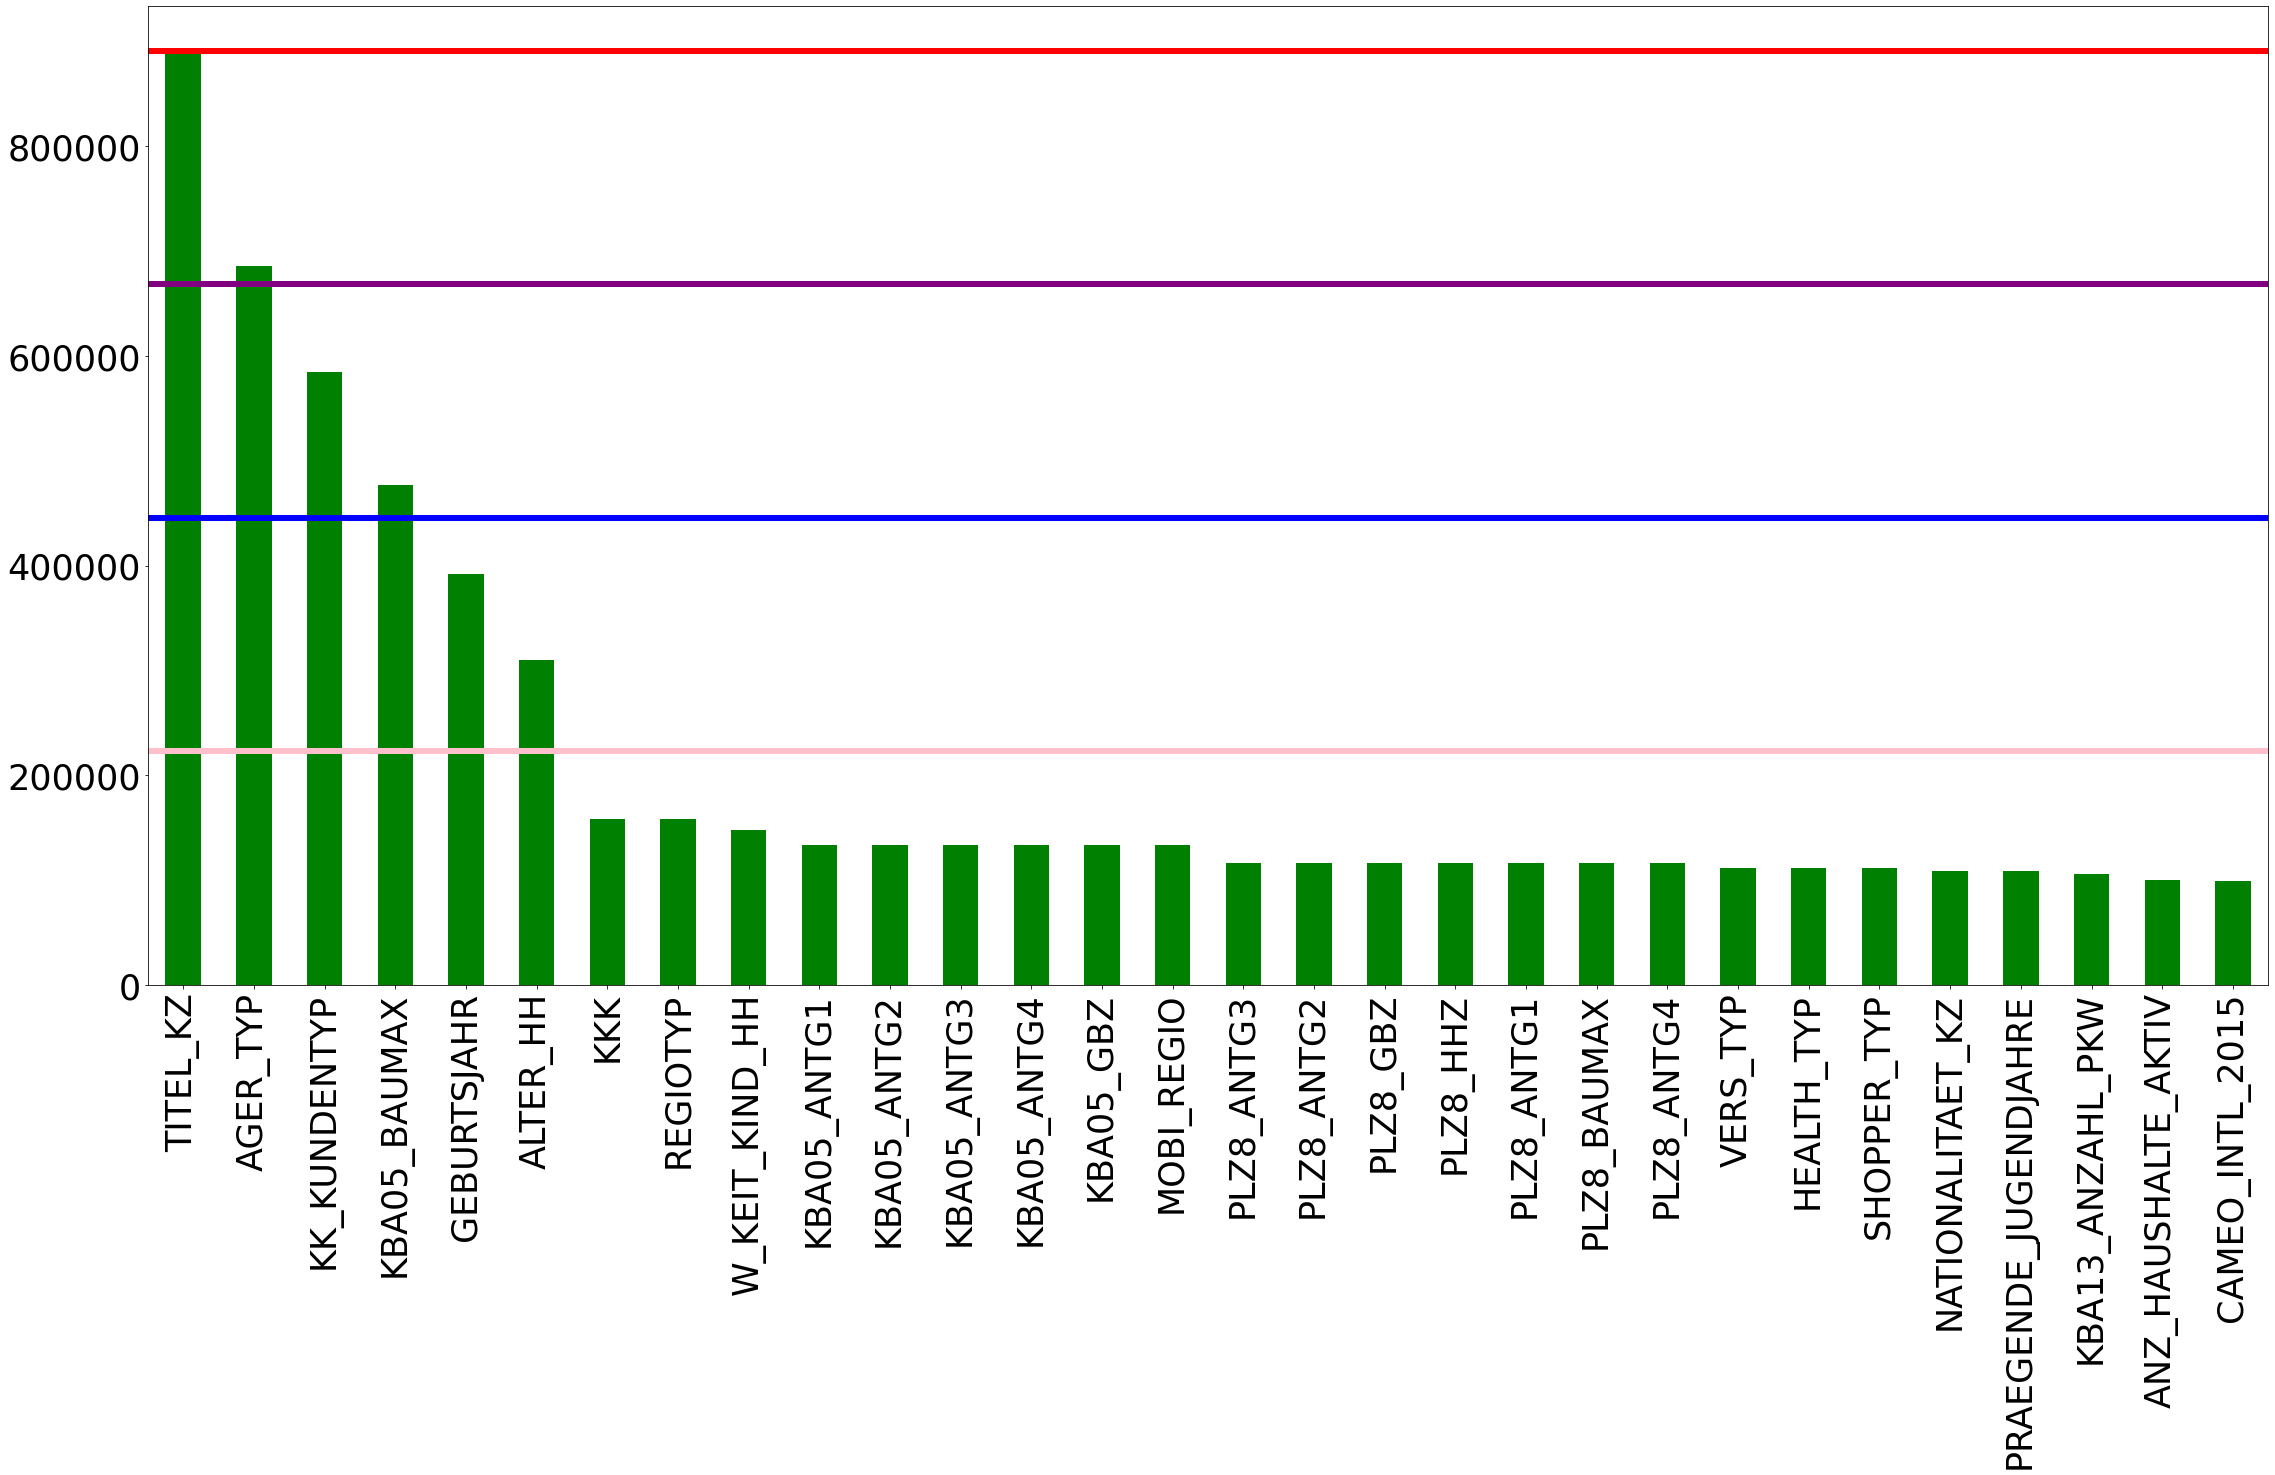

In [18]:
# Plotting the number of NaNs per feature
n_records = azdias.shape[0]
x[:30].plot(kind='bar', figsize=(38,18), fontsize=35, color='green')
plt.axhline(y = n_records, color='r', linewidth=6, label ='100% of records')
plt.axhline(y = n_records*0.75, color='purple', linewidth=6, label ='75% of records')
plt.axhline(y = n_records*0.5, color='blue', linewidth=6, label ='50% of records')
plt.axhline(y = n_records*0.25, color='pink', linewidth=6, label ='25% of records');

In [19]:
# Investigate patterns in the amount of missing data in each column.
na_columns = x.index[:30]
na_columns
azdias[na_columns].describe()

,TITEL_KZ,AGER_TYP,KK_KUNDENTYP,KBA05_BAUMAX,GEBURTSJAHR,ALTER_HH,KKK,REGIOTYP,W_KEIT_KIND_HH,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,MOBI_REGIO,PLZ8_ANTG3,PLZ8_ANTG2,PLZ8_GBZ,PLZ8_HHZ,PLZ8_ANTG1,PLZ8_BAUMAX,PLZ8_ANTG4,VERS_TYP,HEALTH_TYP,SHOPPER_TYP,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,KBA13_ANZAHL_PKW,ANZ_HAUSHALTE_AKTIV
count,2160.000000,205378.000000,306609.000000,414697.000000,498903.000000,580954.000000,733157.000000,733157.000000,743233.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,780025.000000,780025.000000,780025.000000,782906.000000,783057.000000,785421.000000,791610.000000
mean,1.318519,1.743410,3.410640,2.539534,1967.102689,15.291805,2.723384,4.472086,4.147141,1.494277,1.265584,0.624525,0.305927,3.158580,2.963540,1.595426,2.801858,3.381087,3.612821,2.253330,1.943913,0.699166,1.511166,2.190129,1.590134,1.168889,9.280709,619.701439,8.354924
std,0.999504,0.674312,1.628844,1.693151,17.795208,3.800536,0.979867,1.836357,1.784211,1.403961,1.245178,1.013443,0.638725,1.329537,1.428882,0.986736,0.920309,1.111598,0.973967,0.972008,1.459654,0.727137,0.499876,0.755213,1.027972,0.475075,4.032107,340.034318,15.673731
min,1.000000,1.000000,1.000000,1.000000,1900.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,1.000000,1.000000,2.000000,1.000000,1955.000000,13.000000,2.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000,3.000000,3.000000,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,1.000000,6.000000,384.000000,2.000000
50%,1.000000,2.000000,3.000000,1.000000,1968.000000,16.000000,3.000000,5.000000,4.000000,1.000000,1.000000,0.000000,0.000000,3.000000,3.000000,2.000000,3.000000,3.000000,4.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,9.000000,549.000000,4.000000
75%,1.000000,2.000000,5.000000,4.000000,1981.000000,18.000000,3.000000,6.000000,6.000000,3.000000,2.000000,1.000000,0.000000,4.000000,4.000000,2.000000,3.000000,4.000000,4.000000,3.000000,3.000000,1.000000,2.000000,3.000000,2.000000,1.000000,14.000000,778.000000,10.000000
max,5.000000,3.000000,6.000000,5.000000,2017.000000,21.000000,4.000000,7.000000,6.000000,4.000000,4.000000,3.000000,2.000000,5.000000,6.000000,3.000000,4.000000,5.000000,5.000000,4.000000,5.000000,2.000000,2.000000,3.000000,3.000000,3.000000,15.000000,2300.000000,595.000000


In [20]:

azdias[na_columns].head(15)

,TITEL_KZ,AGER_TYP,KK_KUNDENTYP,KBA05_BAUMAX,GEBURTSJAHR,ALTER_HH,KKK,REGIOTYP,W_KEIT_KIND_HH,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,MOBI_REGIO,PLZ8_ANTG3,PLZ8_ANTG2,PLZ8_GBZ,PLZ8_HHZ,PLZ8_ANTG1,PLZ8_BAUMAX,PLZ8_ANTG4,VERS_TYP,HEALTH_TYP,SHOPPER_TYP,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,KBA13_ANZAHL_PKW,ANZ_HAUSHALTE_AKTIV,CAMEO_INTL_2015
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,5.0,1996.0,NaN,2.0,3.0,3.0,0.0,0.0,0.0,2.0,1.0,1.0,2.0,3.0,4.0,5.0,2.0,1.0,1.0,2.0,3.0,3.0,1.0,14.0,963.0,11.0,51
2,NaN,NaN,NaN,NaN,1979.0,17.0,2.0,2.0,3.0,1.0,3.0,1.0,0.0,3.0,3.0,1.0,3.0,4.0,4.0,3.0,1.0,0.0,1.0,3.0,2.0,1.0,15.0,712.0,10.0,24
3,NaN,2.0,NaN,1.0,1957.0,13.0,NaN,NaN,NaN,4.0,1.0,0.0,0.0,4.0,4.0,2.0,2.0,4.0,3.0,2.0,1.0,0.0,1.0,2.0,1.0,1.0,8.0,596.0,1.0,12
4,NaN,NaN,1.0,NaN,1963.0,20.0,3.0,5.0,2.0,1.0,4.0,1.0,0.0,3.0,3.0,2.0,4.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0,8.0,435.0,3.0,43
5,NaN,3.0,3.0,NaN,1943.0,10.0,4.0,5.0,6.0,2.0,2.0,0.0,0.0,4.0,4.0,1.0,3.0,5.0,5.0,2.0,1.0,1.0,2.0,3.0,0.0,1.0,3.0,1300.0,5.0,54
6,NaN,NaN,NaN,1.0,NaN,NaN,3.0,5.0,3.0,3.0,2.0,0.0,0.0,3.0,5.0,1.0,3.0,5.0,5.0,3.0,1.0,0.0,1.0,2.0,1.0,1.0,10.0,867.0,4.0,22
7,NaN,NaN,NaN,NaN,1964.0,14.0,1.0,1.0,5.0,2.0,2.0,0.0,0.0,4.0,4.0,1.0,3.0,4.0,4.0,3.0,1.0,0.0,1.0,1.0,0.0,1.0,8.0,758.0,6.0,14
8,NaN,NaN,NaN,NaN,1974.0,16.0,1.0,3.0,5.0,1.0,1.0,0.0,0.0,5.0,3.0,2.0,3.0,3.0,3.0,2.0,1.0,1.0,2.0,3.0,3.0,1.0,11.0,511.0,2.0,13
9,NaN,NaN,6.0,NaN,1975.0,17.0,1.0,1.0,4.0,1.0,3.0,1.0,0.0,2.0,3.0,2.0,3.0,3.0,3.0,2.0,1.0,1.0,2.0,2.0,3.0,1.0,15.0,530.0,9.0,15


In [21]:
azdias.drop(na_columns[:6], axis=1, inplace=True)

In [22]:
def remove_nas_columns(dataset):
   
    
    flag_to_remove = 0
    
    col_na = dataset.isnull().sum()
    col_na.sort_values(ascending=False, inplace=True)
    
    n_records = dataset.shape[0]
    
    quarter_of_records = n_records * 0.20
        
    # If column has more than 25% missing values, then drop
    for value in col_na:
        print(value)
        if float(value) >= quarter_of_records:
            flag_to_remove += 1
            print(flag_to_remove,quarter_of_records,n_records)

    #print("Removing columns with NAs..: {}\n".format(col_na[:flag_to_remove]))    
    dataset.drop(col_na[:flag_to_remove], axis=1, inplace= True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Most of the NAs in each column is less than 200000. So I am going to remove the columns having NAs more than 200000.('AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX')

Patterns in missing values:
1)LP_LEBENSPHASE_FEIN &LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN & LP_FAMILIE_GROB,LP_STATUS_FEIN & lP_STATUS_GROB, CAMEO_DEUG_2015 & CAMEO_DEU_2015& CAMEO_INTL_2015 have same number of missing values. They represent similar information but in different scale, maybe we can just keep one.

2)KBA05_ANTG1& KBA05_ANTG2 & KBA05_ANTG3& KBA05_ANTG4 have same number of missing values.They represent the information in the same geographical location. Same as PLZ8_ANTG1 & PLZ8_ANTG2 & PLZ8_ANTG3 & PLZ8_ANTG4 PLZ8_BAUMAX & PLZ8_HHZ&PLZ8_GBZ

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [23]:
# How much data is missing in each row of the dataset?
def remove_nas_rows(dataset):
    
    print("Splitting records with NAs..\n",
         "Total records: {}".format(dataset.shape[0]))
    rows_NA = dataset.isnull().sum(axis=1)
    #rows_NA.drop(labels=rows_NA[rows_NA[:] <= 0].index, inplace=True)
    
    n_columns = dataset.shape[1]
    
    quarter_of_columns = int(n_columns * 0.30)
    
    rows_NA_low = rows_NA[rows_NA < quarter_of_columns]
    rows_NA_high = rows_NA[rows_NA >= quarter_of_columns]
    
    print("Records split by {} missing values.\n".format(quarter_of_columns), 
          "Shape of resulting dataset: {}\n".format(rows_NA_low.shape),
          "Shape of high NAs dataset: {}\n".format(rows_NA_high.shape))
    

    df_low = dataset[dataset.index.isin(rows_NA_low.index)]
    df_high = dataset[dataset.index.isin(rows_NA_high.index)]
    return df_low, df_high


In [24]:
rows_NA = azdias.isnull().sum(axis=1)
populated_rows = rows_NA[rows_NA[:] <= 0]
#rows_NA.drop(labels=populated_rows.index, inplace=True)

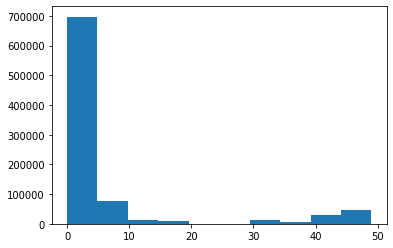

In [25]:


plt.hist(rows_NA);

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
rows_NA_low = rows_NA[rows_NA < 20]
rows_NA_high = rows_NA[rows_NA >= 20]

print(rows_NA_low.shape,rows_NA_high.shape)

(797077,) (94144,)


In [27]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
populated_cols = x[x == 0][:6].index
populated_cols

Index(['FINANZ_UNAUFFAELLIGER', 'FINANZTYP', 'FINANZ_HAUSBAUER',
       'GREEN_AVANTGARDE', 'FINANZ_SPARER', 'FINANZ_MINIMALIST'],
      dtype='object')

In [28]:
azdias[populated_cols][azdias.index.isin(rows_NA_high.index)].head()

,FINANZ_UNAUFFAELLIGER,FINANZTYP,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,FINANZ_SPARER,FINANZ_MINIMALIST
0,5,4,3,0,4,3
11,5,4,3,0,4,3
14,5,4,3,0,4,3
17,5,4,3,0,4,3
24,5,4,3,0,4,3


In [29]:
def dist_data_plot(column):
    
    x_21 = azdias[column][azdias.index.isin(rows_NA_low.index)]
    x_22 = azdias[column][azdias.index.isin(rows_NA_high.index)]
    
    plt.subplot(1,2,1)
    sns.countplot(x = x_21, data=azdias)
    plt.title("Low NAs")
    
    plt.subplot(1,2,2)
    sns.countplot(x = x_22, data=azdias)
    plt.title("High NAs")

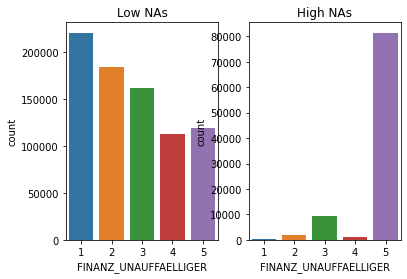

In [30]:
dist_data_plot(populated_cols[0])

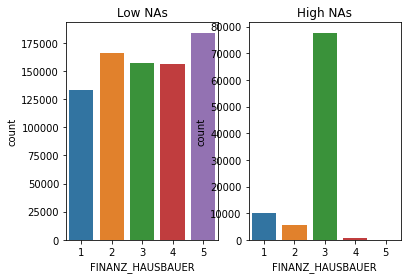

In [31]:
dist_data_plot(populated_cols[2])

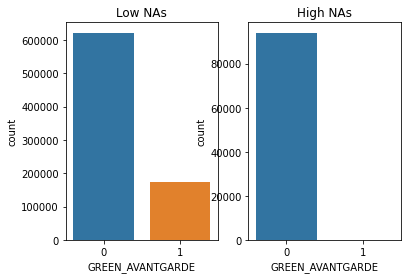

In [32]:
dist_data_plot(populated_cols[3])

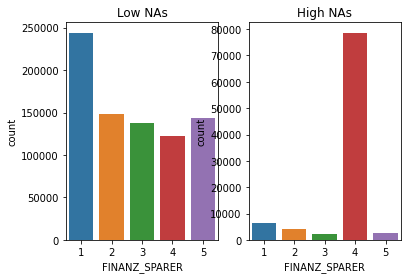

In [33]:
dist_data_plot(populated_cols[4])

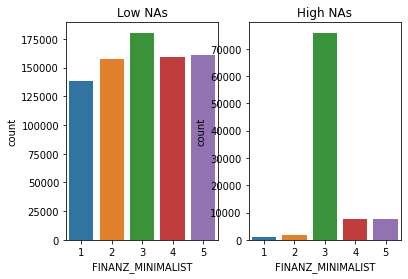

In [34]:
dist_data_plot(populated_cols[5])

#### Discussion 1.1.3: Assess Missing Data in Each Row

In the distribution of values of the five columns, there are no NAs, we can find out that the data subset with lots of missing values usually have the same value in each column, and the value is as the same as the most frequent value of the data subset with less NAs. So, you can remove the data subset with lots of missing values.

In [35]:
azdias_updated = azdias[azdias.index.isin(rows_NA_low.index)]

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [36]:
# How many features are there of each data type?
feat_info.groupby(['type']).count()

,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [37]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
feat_info_updated = feat_info[feat_info.attribute.isin(azdias_updated.columns)]
feat_info_updated.groupby(['type']).count()


,attribute,information_level,missing_or_unknown
type,,,
categorical,18,18,18
mixed,6,6,6
numeric,6,6,6
ordinal,49,49,49


In [38]:
# Re-encode categorical variable(s) to be kept in the analysis.
categorical_cols = feat_info_updated.attribute[feat_info_updated.type == 'categorical']
categorical_cols.tolist()


['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [39]:
azdias_updated[categorical_cols].describe()

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP
count,797077.000000,792445.000000,797077.000000,792445.000000,797077.000000,766095.000000,766095.000000,792445.000000,792445.000000,763512.000000,760739.000000,797077.000000,760739.000000,797077.000000,797077.000000
mean,1.521377,3.502618,3.799344,7.470821,0.219722,3.911692,2.377401,4.790031,2.459853,1.168554,1.578349,0.008414,1.518070,3.379054,2.799820
std,0.499543,1.537409,2.084767,3.574600,0.414058,3.936602,1.699496,3.520677,1.511788,0.474735,1.026083,0.091344,0.499674,1.407834,2.657595
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,2.000000,4.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.000000,1.000000
50%,2.000000,4.000000,4.000000,8.000000,0.000000,1.000000,1.000000,4.000000,2.000000,1.000000,2.000000,0.000000,2.000000,3.000000,1.000000
75%,2.000000,5.000000,6.000000,11.000000,0.000000,8.000000,4.000000,9.000000,4.000000,1.000000,2.000000,0.000000,2.000000,4.000000,3.000000
max,2.000000,6.000000,6.000000,12.000000,1.000000,11.000000,5.000000,10.000000,5.000000,3.000000,3.000000,1.000000,2.000000,6.000000,8.000000


In [40]:
azdias_updated[categorical_cols].describe(include=['object'])

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
count,797077,791210,791210
unique,2,9,44
top,W,8,6B
freq,628695,134394,56642


In [41]:
for col in categorical_cols:
    print(azdias_updated[col].value_counts())

2    415578
1    381499
Name: ANREDE_KZ, dtype: int64
4.0    198089
3.0    147068
2.0    141166
5.0    111032
6.0    101898
1.0     93192
Name: CJT_GESAMTTYP, dtype: int64
6    289004
1    196805
5    106220
2    104577
4     55874
3     44597
Name: FINANZTYP, dtype: int64
12.0    129983
10.0    102748
8.0      82992
11.0     75051
5.0      70468
4.0      60413
9.0      57046
3.0      53094
1.0      50640
2.0      43647
7.0      40642
6.0      25721
Name: GFK_URLAUBERTYP, dtype: int64
0    621942
1    175135
Name: GREEN_AVANTGARDE, dtype: int64
1.0     402248
10.0    128902
2.0      98491
11.0     48727
8.0      21777
7.0      19568
4.0      11573
5.0      11164
9.0      10451
6.0       8512
3.0       4682
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    402248
5.0    188080
2.0     98491
4.0     49857
3.0     27419
Name: LP_FAMILIE_GROB, dtype: int64
1.0     206766
9.0     136229
10.0    111538
2.0     111016
4.0      73938
3.0      68893
6.0      28870
5.0      27472
8.0      18525
7.0    

In [42]:
def imputer_freq(feat_info, var): #fill in NaN with most common value in column
    most_freq = feat_info[var].value_counts().idxmax()
    return feat_info[var].fillna(most_freq)

In [43]:
cat_col = dict()
for col in categorical_cols:
    if (azdias_updated[col].nunique() > 2):
        cat_col.setdefault('multi',[])
        cat_col['multi'].append(col)
    else:                
        cat_col.setdefault('binary',[])
        cat_col['binary'].append(col)

In [44]:
cat_col

{'binary': ['ANREDE_KZ',
  'GREEN_AVANTGARDE',
  'SOHO_KZ',
  'VERS_TYP',
  'OST_WEST_KZ'],
 'multi': ['CJT_GESAMTTYP',
  'FINANZTYP',
  'GFK_URLAUBERTYP',
  'LP_FAMILIE_FEIN',
  'LP_FAMILIE_GROB',
  'LP_STATUS_FEIN',
  'LP_STATUS_GROB',
  'NATIONALITAET_KZ',
  'SHOPPER_TYP',
  'ZABEOTYP',
  'GEBAEUDETYP',
  'CAMEO_DEUG_2015',
  'CAMEO_DEU_2015']}

#### Discussion 1.2.1: Re-Encode Categorical Features

You can remove categorical variables with so many levels(more than 10):'GFK_URLAUBERTYP','LP_FAMILIE_FEIN','CAMEO_DEU_2015' Re-encode categorical variable(s): OST_WEST_KZ Reengineering : one hot encoding with the left categorical variables

In [45]:
# Re-encoding the binary column OST_WEST_KZ with numerical values
azdias_updated['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)

# Dropping the CAMEO_DEU_2015 since it will add several additional columns
# when re-encoding it
azdias_updated.drop('CAMEO_DEU_2015', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [46]:
# For the multi level columns, I will use get_dummies
# First, updating the cat_col list, removing the CAMEO_DEU_2015 from the dictionary
cat_col['multi'].pop()

'CAMEO_DEU_2015'

In [47]:
azdias_updated = pd.get_dummies(azdias_updated, columns=cat_col['multi'])
azdias_updated.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

#### Discussion 1.2.2: Engineer Mixed-Type Features

From the data_dictionary.md file:

##### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [48]:

mainstream = (1,3,5,8,10,12,14)

In [49]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
col_move= np.where(azdias_updated['PRAEGENDE_JUGENDJAHRE'].isin(mainstream), 0, 
                   np.where(azdias_updated['PRAEGENDE_JUGENDJAHRE'].notnull(), 1, np.nan))
for col1, col2 in zip(azdias_updated['PRAEGENDE_JUGENDJAHRE'],col_move):
    print(col1,col2)

Streaming output truncated to the last 5000 lines.
14.0 0.0
8.0 0.0
14.0 0.0
15.0 1.0
3.0 0.0
14.0 0.0
5.0 0.0
4.0 1.0
8.0 0.0
11.0 1.0
3.0 0.0
8.0 0.0
2.0 1.0
14.0 0.0
8.0 0.0
10.0 0.0
1.0 0.0
4.0 1.0
14.0 0.0
1.0 0.0
5.0 0.0
14.0 0.0
10.0 0.0
10.0 0.0
15.0 1.0
10.0 0.0
10.0 0.0
10.0 0.0
1.0 0.0
1.0 0.0
14.0 0.0
10.0 0.0
14.0 0.0
1.0 0.0
11.0 1.0
14.0 0.0
11.0 1.0
14.0 0.0
5.0 0.0
14.0 0.0
10.0 0.0
10.0 0.0
10.0 0.0
14.0 0.0
8.0 0.0
15.0 1.0
10.0 0.0
9.0 1.0
5.0 0.0
14.0 0.0
5.0 0.0
10.0 0.0
8.0 0.0
4.0 1.0
14.0 0.0
10.0 0.0
14.0 0.0
8.0 0.0
14.0 0.0
4.0 1.0
8.0 0.0
3.0 0.0
9.0 1.0
8.0 0.0
14.0 0.0
10.0 0.0
3.0 0.0
nan nan
14.0 0.0
4.0 1.0
6.0 1.0
14.0 0.0
nan nan
8.0 0.0
14.0 0.0
10.0 0.0
10.0 0.0
8.0 0.0
8.0 0.0
15.0 1.0
8.0 0.0
10.0 0.0
3.0 0.0
8.0 0.0
6.0 1.0
14.0 0.0
2.0 1.0
14.0 0.0
8.0 0.0
8.0 0.0
15.0 1.0
11.0 1.0
5.0 0.0
5.0 0.0
10.0 0.0
3.0 0.0
11.0 1.0
5.0 0.0
10.0 0.0
14.0 0.0
14.0 0.0
14.0 0.0
14.0 0.0
8.0 0.0
5.0 0.0
14.0 0.0
15.0 1.0
10.0 0.0
11.0 1.0
5.0 0.0
6.0 1.0
8.

In [50]:
azdias_updated['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = col_move

azdias_updated[['PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_MOVEMENT']].head(5)

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_MOVEMENT
1,14.0,0.0
2,15.0,1.0
3,8.0,0.0
4,8.0,0.0
5,3.0,0.0


In [51]:
decade = {1:40,2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}

In [52]:
col_dec = azdias_updated['PRAEGENDE_JUGENDJAHRE'].map(decade)

for col1, col2 in zip(azdias_updated['PRAEGENDE_JUGENDJAHRE'],col_dec):
    print(col1,col2)

Streaming output truncated to the last 5000 lines.
14.0 90.0
8.0 70.0
14.0 90.0
15.0 90.0
3.0 50.0
14.0 90.0
5.0 60.0
4.0 50.0
8.0 70.0
11.0 80.0
3.0 50.0
8.0 70.0
2.0 40.0
14.0 90.0
8.0 70.0
10.0 80.0
1.0 40.0
4.0 50.0
14.0 90.0
1.0 40.0
5.0 60.0
14.0 90.0
10.0 80.0
10.0 80.0
15.0 90.0
10.0 80.0
10.0 80.0
10.0 80.0
1.0 40.0
1.0 40.0
14.0 90.0
10.0 80.0
14.0 90.0
1.0 40.0
11.0 80.0
14.0 90.0
11.0 80.0
14.0 90.0
5.0 60.0
14.0 90.0
10.0 80.0
10.0 80.0
10.0 80.0
14.0 90.0
8.0 70.0
15.0 90.0
10.0 80.0
9.0 70.0
5.0 60.0
14.0 90.0
5.0 60.0
10.0 80.0
8.0 70.0
4.0 50.0
14.0 90.0
10.0 80.0
14.0 90.0
8.0 70.0
14.0 90.0
4.0 50.0
8.0 70.0
3.0 50.0
9.0 70.0
8.0 70.0
14.0 90.0
10.0 80.0
3.0 50.0
nan nan
14.0 90.0
4.0 50.0
6.0 60.0
14.0 90.0
nan nan
8.0 70.0
14.0 90.0
10.0 80.0
10.0 80.0
8.0 70.0
8.0 70.0
15.0 90.0
8.0 70.0
10.0 80.0
3.0 50.0
8.0 70.0
6.0 60.0
14.0 90.0
2.0 40.0
14.0 90.0
8.0 70.0
8.0 70.0
15.0 90.0
11.0 80.0
5.0 60.0
5.0 60.0
10.0 80.0
3.0 50.0
11.0 80.0
5.0 60.0
10.0 80.0
14.0 90.0

In [53]:
azdias_updated['PRAEGENDE_JUGENDJAHRE_DECADE'] = col_dec

azdias_updated[['PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_DECADE']].head(5)

,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_DECADE
1,14.0,90.0
2,15.0,90.0
3,8.0,70.0
4,8.0,70.0
5,3.0,50.0


#### Investigate "CAMEO_INTL_2015" and engineer two new variables.

From the data_dictionary file:

CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [54]:
def split_cameo(value,wealth):
    
        if pd.isnull(value):
            return np.nan

        elif wealth:
            return(int(value[0])) 

        else:
            return(int(value[1]))
            #print(value,value[0],value[1])        
    #type(cameo_values)


In [55]:
azdias_updated['CAMEO_INTL_2015_WEALTH']= azdias_updated['CAMEO_INTL_2015'].apply(split_cameo,wealth=1)
azdias_updated['CAMEO_INTL_2015_LIFESTAGE']= azdias_updated['CAMEO_INTL_2015'].apply(split_cameo,wealth=0)

azdias_updated[['CAMEO_INTL_2015','CAMEO_INTL_2015_WEALTH','CAMEO_INTL_2015_LIFESTAGE']].head(5)

,CAMEO_INTL_2015,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0
5,54,5.0,4.0


In [56]:
azdias_updated.drop(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE','LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [57]:
azdias_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Columns: 151 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFESTAGE
dtypes: float64(44), int64(23), uint8(84)
memory usage: 477.4 MB


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [58]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    replace_missing_values(df, feature_dict)
    
    # remove selected columns and rows, ...
    # Please note that na_columns is an array that contains the column names with more NAs:
    # TITEL_KZ,AGER_TYP,KK_KUNDENTYP,KBA05_BAUMAX,GEBURTSJAHR,ALTER_HH
    df.drop(na_columns[:6], axis=1, inplace=True)
    df, df_high_na = remove_nas_rows(df)

    # select, re-encode, and engineer column values.
    df['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    df.drop('CAMEO_DEU_2015', axis=1, inplace=True)
    df = pd.get_dummies(df, columns=cat_col['multi'])
    
    col_move= np.where(df['PRAEGENDE_JUGENDJAHRE'].isin(mainstream), 0, 
                   np.where(df['PRAEGENDE_JUGENDJAHRE'].notnull(), 1, np.nan))
    col_dec = df['PRAEGENDE_JUGENDJAHRE'].map(decade)
    
    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = col_move
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = col_dec
    
    df['CAMEO_INTL_2015_WEALTH']= df['CAMEO_INTL_2015'].apply(split_cameo,wealth=1)
    df['CAMEO_INTL_2015_LIFESTAGE']= df['CAMEO_INTL_2015'].apply(split_cameo,wealth=0)
    
    df.drop(['CAMEO_INTL_2015','PRAEGENDE_JUGENDJAHRE','LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    
    return df, df_high_na


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputerr](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.SimpleImputerr.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [59]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputed_features = imputer.fit_transform(azdias_updated)

In [ ]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(imputed_features)

### Discussion 2.1: Apply Feature Scaling

In the NAs imputation strategy:

I used median instead of mean to imputate the NAs, because all of the numeric variables are intergers in this case, means will bring float number into the dataset.
The imputation strategy with “median” is to replace missing values using the median along each column. It can only be used with numeric data.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [ ]:
def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [ ]:
n_comp = int(scaled_features.shape[1] / 2)

pca, X_pca = do_pca(n_components = n_comp, data=scaled_features)

In [ ]:

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [ ]:
scree_plot(pca)

In [ ]:
def get_component(dataset,desired_variance):
    variance = 0
    for component in range(0,100):
        pca, X_pca = do_pca(n_components=component+1, data=dataset)
        variance += pca.explained_variance_ratio_[component]
        #print(variance,pca.explained_variance_ratio_[component] )

        if variance >= desired_variance:
            print("The number of components needed to obtain {} of variance is {}".format(variance,component+1))
            return component+1
comp = get_component(scaled_features,0.85)
#comp = 72

In [ ]:
pca, X_pca = do_pca(n_components = comp, data=scaled_features)

### Discussion 2.2: Perform Dimensionality Reduction

A good choice is 85 components for the next step in the analysis as it explains more than 80% variances while reducing the number of features by more than 99%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [67]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def plot_component(full_dataset, pca, n_components, color='purple'):
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    components = components.iloc[n_components-1]

    comp_pos =  components.sort_values(ascending=False)[:10]
    comp_neg = components.sort_values(ascending=True)[:10]
    comp_merged = pd.concat([comp_pos, comp_neg])
    comp_merged

    comp_merged.plot(kind='bar', color=color, title=dimensions[n_components-1])

#comp_end = components.sort_values(ascending=True)[:10]

In [ ]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_component(azdias_updated,pca,1)


In [ ]:
plot_component(azdias_updated,pca,2)

In [ ]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_component(azdias_updated,pca,3)

### Discussion 2.3: Interpret Principal Components

 we have: 
HH_EINKOMMEN_SCORE (Estimated household net income)
LP_STATUS_GROB_1 (low-income earners)
FINANZ_HAUSBAUER (home ownership)
CAMEO_INTL_2015_WEALTH
PLZ8_ANTG3, PLZ8_ANTG4 (Number of 6-10  and 10+ family houses in the PLZ8 region).

as the features with the highest positive weights. On the other hand, we have:

MOBI_REGIO (Movement patterns)
FINANZ_MINIMALIST (low financial interest)
PLZ8_ANTG1 (Number of 1-2 family houses in the PLZ8 region)
KBA05_GBZ (Number of buildings in the microcell)
KBA05_ANTG1 (Number of 1-2 family houses in the microcell)
KONSUMNAEHE (Distance from building to point of sale (PoS))
LP_STATUS_GROB_4 (houseowners )

which are the features with the highest negative weights. So, based on these prominent feaures, we can say that the __component 1__ is describing the relationship between __wealth, income, movement paterns and share family houses__. 


For the second component, we have:
FINANZ_VORSORGER (Financial typology, VORSORGER: be prepared)
ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
ZABEOTYP (Energy consumption typology, 3: fair supplied)
FINANZ_MINIMALIST (MINIMALIST: low financial interest)

as the features with the highest positive weights. On the other hand, we have:

FINANZ_SPARER (SPARER: money-saver)
PRAEGENDE_JUGENDJAHRE_DECADE (decade of movement of person's youth)
FINANZ_UNAUFFAELLIGER (UNAUFFAELLIGER: inconspicuous)
FINANZ_ANLEGER (ANLEGER: investor)
SEMIO_REL (REL: religious)
SEMIO_TRADV (TRADV: tradional-minded)
SEMIO_PFLICHT (PFLICHT: dutiful)

which are the features with the highest negative weights. So, we can conclude that the __second component__ describes the relationship between the __Age, Financial status, decade of movement and some personality traits__.

For the third component, we have:

SEMIO_VERT :Personality typology, for each dimension (VERT: dreamful)
SEMIO_KULT (KULT: cultural-minded)
SEMIO_FAM (FAM: family-minded)
SEMIO_SOZ (SOZ: socially-minded)
SEMIO_MAT  (MAT: materialistic)
FINANZTYP: Most descriptive financial type for individual( 5: investor (ANLEGER))
SHOPPER_TYP: Shopper typology (1: Shopping-stressed)
SEMIO_REL (REL: Religious)

as the features with the highest positive weights. On the other hand, we have:

ANREDE_KZ: Gender
SEMIO_KAEM (KAEM: combative attitude)
SEMIO_DOM (DOM: dominant-minded)
SEMIO_KRIT (KRIT: critical-minded)
SEMIO_ERL (ERL: event-oriented)

which are the features with the highest negative weights.  So we can say that the __third component__ describes the relationship between the __personality and gender__.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
sample_pca = X_pca[np.random.choice(X_pca.shape[0], int(X_pca.shape[0]*0.25))]


In [ ]:
distance = np.arange(30)

for cluster in range(30):
  model = KMeans(cluster+1).fit(sample_pca)
  distance[cluster] = abs(model.score(sample_pca))

In [ ]:
plt.plot(range(1,distance.size+1), distance, marker='o')
plt.xlabel("Clusters")
plt.ylabel("Distance between points and centers");

In [74]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

model = KMeans(20, random_state=42).fit(X_pca)

In [75]:
kmeans_general = model.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

Using the 60 principal components, I used a k-means approach to perform clustering on the data. First, I wanted to find the optimal number of clusters k. I tested a range of 1 to 30 clusters, each time saving the inertia, which is the sum of samples’ squared distances to their closest cluster center. I then plotted the inertias for each k.
The elbow method is a good, if not entirely accurate, way to determine the optimal number of clusters. The elbow point is when adding more clusters only leads to diminishing returns, i.e., where the curve begins to flatten. I have set the elbow point to 20, which indicates that the optimal number of clusters k is 20.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [76]:
customers=pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')


In [77]:
customers, customers_high_nas = clean_data(df=customers)

Splitting records with NAs..
 Total records: 191652
Records split by 23 missing values.
 Shape of resulting dataset: (141673,)
 Shape of high NAs dataset: (49979,)



/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [78]:
customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,5.0,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,0.0,1.0,2.0,0.0,1.0,6.0,9.0,1.0,0.0,5.0,1992.0,1,7.0,2.0,2.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1.0,50.0,1.0,3.0
2,4.0,2,5,1,5,1,4,4,1,2.0,3.0,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,0.0,2.0,1.0,0.0,1.0,6.0,9.0,1.0,0.0,1.0,1992.0,1,2.0,2.0,2.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1.0,50.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,NaN,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0.0,1.0,0.0,0.0,4.0,NaN,9.0,NaN,NaN,2.0,1992.0,1,7.0,3.0,0.0,0.0,0.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0.0,40.0,2.0,4.0
4,3.0,1,3,1,4,4,5,2,0,3.0,10.0,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,0.0,2.0,4.0,0.0,6.0,2.0,9.0,7.0,0.0,1.0,1992.0,1,3.0,0.0,3.0,2.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0.0,70.0,4.0,1.0
5,3.0,1,5,1,5,1,2,3,1,3.0,5.0,3.0,6

In [79]:
def add_missing_dummy_columns(d, columns):
    missing_cols = set(columns) - set(d.columns)
    print(missing_cols)
    for c in missing_cols:
        d[c] = 0
           
def fix_columns(d, columns):  
    add_missing_dummy_columns(d, columns)
    # make sure we have all the columns we need
    assert(set(columns) - set(d.columns) == set())
    extra_cols = set(d.columns) - set(columns)
    if extra_cols:
        print("extra columns:", extra_cols)
    d = d[columns]
    return d
customers = fix_columns(customers, azdias_updated.columns.tolist())


{'GEBAEUDETYP_5.0'}


In [80]:
imputed_features_customers = imputer.transform(customers)
scaled_customers = scaler.transform(imputed_features_customers)

In [81]:

pca_customers = pca.transform(scaled_customers)

kmeans_customers = model.predict(pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [82]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

gral_high_nas = azdias[azdias.index.isin(rows_NA_high.index)]
kmeans_high_nas_gral = np.full((gral_high_nas.shape[0],), 20)
kmeans_high_nas_cust = np.full((customers_high_nas.shape[0],), 20)

In [83]:
kmeans_gral_org = kmeans_general
kmeans_cust_org = kmeans_customers
kmeans_general = np.concatenate((kmeans_general,kmeans_high_nas_gral))
kmeans_customers = np.concatenate((kmeans_customers,kmeans_high_nas_cust))



891221
191652


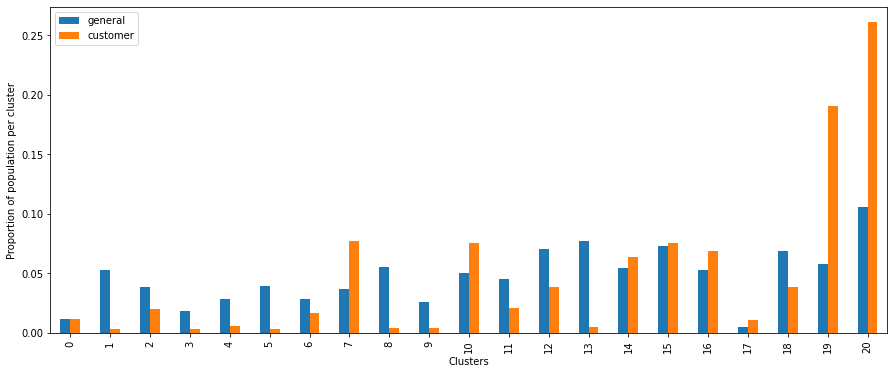

In [84]:

gral_prop = np.bincount(kmeans_general)/len(kmeans_general)
print(len(kmeans_general))
cust_prop = np.bincount(kmeans_customers)/len(kmeans_customers)
print(len(kmeans_customers))

full_prop = pd.DataFrame({'general': gral_prop, 'customer': cust_prop})

full_prop.plot(kind='bar', figsize=[15,6])
plt.xlabel('Clusters')
plt.ylabel('Proportion of population per cluster');


In [85]:
print(np.bincount(kmeans_customers))
print(cust_prop)
print(customers.shape)
print(kmeans_customers.sum())

[ 2204   641  3908   679  1147   720  3164 14830   771   751 14421  4110
  7478   983 12230 14444 13140  2045  7404 36603 49979]
[0.01150001 0.0033446  0.02039113 0.00354288 0.00598481 0.00375681
 0.01650909 0.07737983 0.00402292 0.00391856 0.07524576 0.02144512
 0.03901864 0.00512909 0.06381358 0.07536577 0.06856177 0.01067038
 0.03863252 0.19098679 0.26077996]
(141673, 151)
2907532


In [86]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

print(np.bincount(kmeans_general))
print(gral_prop)
print(azdias_updated.shape)
print(kmeans_general.sum())

[10398 47283 34798 16813 25574 34836 25472 33211 49755 23339 45018 40254
 62653 69071 48922 64973 47085  4790 61199 51633 94144]
[0.01166714 0.05305418 0.03904531 0.01886513 0.02869546 0.03908795
 0.02858101 0.03726461 0.0558279  0.02618767 0.05051272 0.04516725
 0.07030018 0.07750154 0.05489323 0.07290335 0.05283201 0.00537465
 0.06866871 0.05793512 0.10563485]
(797077, 151)
10439709


In [87]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
differences = full_prop['customer'] - full_prop['general']

# Overrepresented clusters
overrepresented = differences.sort_values(ascending=False)[:3].index
differences.sort_values(ascending=False)[:3]

20    0.155145
19    0.133052
7     0.040115
dtype: float64

In [88]:
underrepresented = differences.sort_values(ascending=True)[:3].index
differences.sort_values(ascending=True)[:3]

13   -0.072372
8    -0.051805
1    -0.049710
dtype: float64

In [89]:
def get_components(cluster, kmeans):
    
    pca_c = kmeans.cluster_centers_[cluster].copy()
    pca_series = pd.Series(pca_c)
    print(pca_series.head(5), pca_series.tail(5))
    pos_comp = pca_series.sort_values(ascending=False)[:3].index
    neg_comp = pca_series.sort_values(ascending=True)[:3].index
    print(pos_comp, neg_comp)
    
    return pos_comp, neg_comp

In [90]:
comp_pos_over, comp_neg_over = get_components(overrepresented[1],model) #We skip the 20 cluster, which is for the high missing values
comp_pos_under, comp_neg_under = get_components(underrepresented[0],model)

0   -4.419551
1   -0.088906
2    3.300989
3    2.434769
4   -1.564985
dtype: float64 67    0.139765
68   -0.060990
69    0.025297
70    0.049183
71   -0.111604
dtype: float64
Int64Index([2, 3, 10], dtype='int64') Int64Index([0, 4, 6], dtype='int64')
0    5.496270
1   -1.897602
2   -2.158480
3    0.817775
4   -0.227095
dtype: float64 67   -0.016614
68   -0.072817
69    0.099375
70    0.056626
71   -0.036918
dtype: float64
Int64Index([0, 9, 3], dtype='int64') Int64Index([2, 1, 7], dtype='int64')


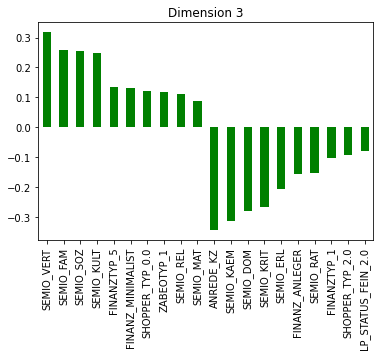

In [91]:
plot_component(full_dataset=customers,n_components=comp_pos_over[0]+1, pca=pca, color='green')

 * It mostly describes the relatioship between personality traits and gender, where men tend to be less dreamful, family-minded, socially-minded and cultural-minded (Positve weights). On the other hand, women tend to be less combative-minded, dominant-minded and critical-minded. (negative weights)

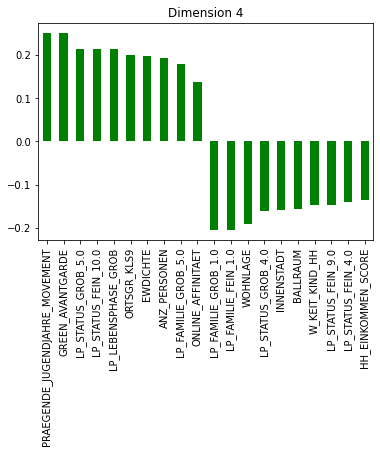

In [92]:
plot_component(full_dataset=customers,n_components=comp_pos_over[1]+1, pca=pca, color='green')

* People/ Families who have high ecological awareness, high income earners, living in big communities. bold text

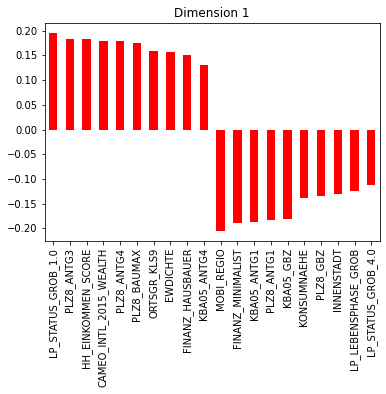

In [93]:
plot_component(full_dataset=azdias_updated,n_components=comp_pos_under[0]+1, pca=pca, color='red' )

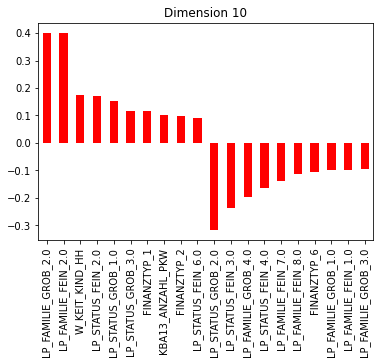

In [94]:
plot_component(full_dataset=azdias_updated,n_components=comp_pos_under[1]+1, pca=pca, color='red' )


* Low income or independent couples with no children (or unlikely to have any) and low financial interest. 

### Discussion 3.3: Compare Customer Data to Demographics Data

In the beginning, I analyzed and cleaned up the existing data. Then I scaled the data and applied PCA to reduce the feature dimensionality. Based on 85 principal components, I identified 16 clusters of which were disproportionately represented in the customer data. All clusters had in common that they contained mostly elderly and affluent individuals.
For the supervised machine learning part, I used the same transformations as for clustering. However, this was not leading to satisfactory results. My assumption that the dropped features still contained relevant information turned out to be correct, as the new transformation pipeline delivered significantly better results. I tested several algorithms. Through hyperparameter tuning, I tested different configurations. The final model was able to achieve a good score of 85%.
I think there are several approaches to how the best score could be further improved. Also, I believe that further feature engineering could lead to significant improvements. With additional hyperparameter tuning, one could probably achieve some (smaller) improvements. If in the future an algorithm is established, it would probably be possible to achieve even better scores.
To analyze the clusters, I grouped the labeled customer dataset by cluster and calculated each feature’s mean. Then I iterated through the features and created a DataFrame containing the clusters with the three highest and the three lowest mean values for each feature. Then, for the clusters representing the dominant customer segments, I analyzed for which features they were the cluster with the highest and lowest average scores, respectively. 
**Cluster 1**
This cluster represents the upper middle class with a high income. Members of this customer segment tend to be less mobile, have a relatively large number of children, and are predominantly fixated on their own homes. People from this cluster live in areas with low unemployment. The formative youth years of this group were primarily the 1970s.
**Cluster 5**
This cluster has the highest proportion of academics and top earners. Compared to cluster 1, members appear to be older because their formative teenage years were the 1950s, where they often belonged to the “green avant-garde.” Members of this group live in very good neighborhoods. People from this category are not very dreamy and are characterized by high financial interest, which translates into a high probability of being an investor.
**Cluster 6**
Cluster 6 is more urban, with more German-sounding names, and tends to be from western Germany. They are often golden agers, i.e., people over 50 years of age. They are rational money savers who are more traditional in terms of consumption and advertising.
In summary, the most represented customer segments consist of rather older people in a good financial situation.

---

To determine which demographic clusters are particularly prevalent in the customer dataset, I formed 15 clusters from the demographic dataset. I cleaned, scaled, and PCA-transformed the customer data. I used the k-means model to assign one of 15 labels to each data point in the customer dataset. 
Finally, It can be seen that especially 3 clusters are dominant. As shown before, The difference of proportion in the customer dataset and the demographic dataset. This graph also confirms that 3 clusters are particularly strongly represented.


---



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.